In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
import string
from collections import Counter

from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from pprint import pprint
import pickle
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, average_precision_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

[nltk_data] Downloading package stopwords to /home/cst/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/cst/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cst/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Functions

In [26]:
def save_as_pickle(filename,obj):    
    with open(filename, 'wb') as fp:
        pickle.dump(obj, fp, protocol=pickle.HIGHEST_PROTOCOL)
    fp.close()

In [27]:
if not os.path.exists('news_data'):
    os.makedirs('news_data')

In [28]:
xls = pd.ExcelFile('News Title.xls')
data = xls.parse('Data Train')

In [29]:
data.shape

(65535, 3)

In [30]:
data.head()

,No,News Title,Category
0,1,Google+ rolls out 'Stories' for tricked out ph...,Technology
1,2,Dov Charney's Redeeming Quality,Business
2,3,White God adds Un Certain Regard to the Palm Dog,Entertainment
3,4,"Google shows off Androids for wearables, cars,...",Technology
4,5,China May new bank loans at 870.8 bln yuan,Business


In [31]:
data.isnull().sum()

No            0
News Title    0
Category      0
dtype: int64

<b>No missing data</b>

In [32]:
data['Category'].value_counts()

Entertainment    23961
Business         17707
Technology       16776
Medical           7091
Name: Category, dtype: int64

In [33]:
data['Category'].value_counts(normalize=True)

Entertainment    0.365621
Business         0.270192
Technology       0.255985
Medical          0.108202
Name: Category, dtype: float64

<b>Data is imbalance, especially for `Medical` category. </b>

In [34]:
data['characters_length'] = data['News Title'].str.len()

In [35]:
data.head()

,No,News Title,Category,characters_length
0,1,Google+ rolls out 'Stories' for tricked out ph...,Technology,58
1,2,Dov Charney's Redeeming Quality,Business,31
2,3,White God adds Un Certain Regard to the Palm Dog,Entertainment,48
3,4,"Google shows off Androids for wearables, cars,...",Technology,50
4,5,China May new bank loans at 870.8 bln yuan,Business,42


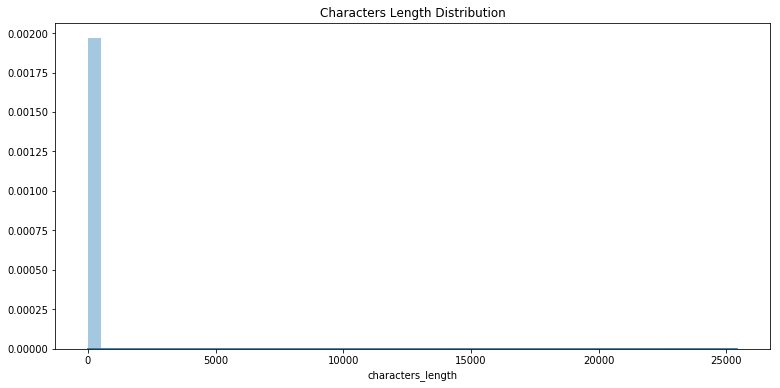

In [36]:
plt.figure(figsize=(12.8,6))
sns.distplot(data['characters_length']).set_title('Characters Length Distribution');

<b>Characters length is super skewed</b>

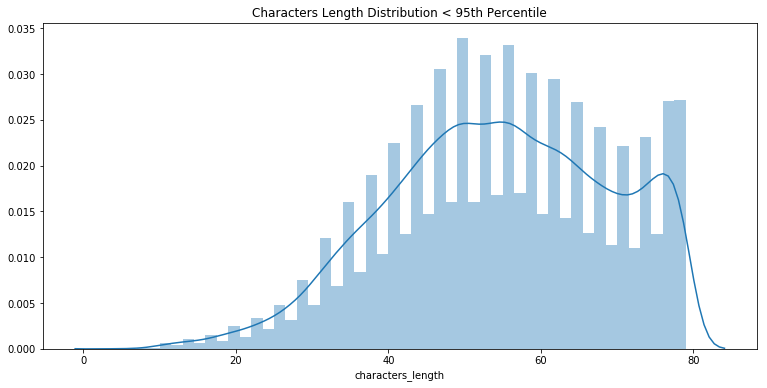

In [37]:
plt.figure(figsize=(12.8,6))
sns.distplot(data[data['characters_length']<np.quantile(data['characters_length'],0.95)]['characters_length']).set_title('Characters Length Distribution < 95th Percentile');

In [38]:
print(data[data['characters_length'] <= np.quantile(data['characters_length'],0.95)].shape[0]/data.shape[0])
print(data[data['characters_length'] > np.quantile(data['characters_length'],0.95)].shape[0]/data.shape[0])

0.9508049134050507
0.04919508659494926


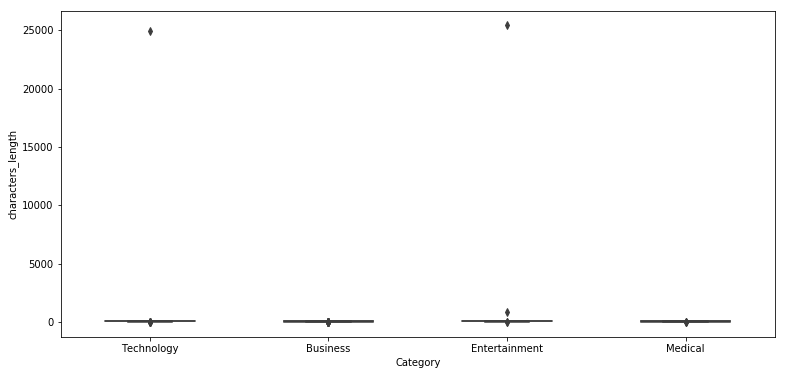

In [39]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=data, x='Category', y='characters_length', width=.5);

<b>Biggest outliers are in `Technology` and `Entertainment` categories.</b>

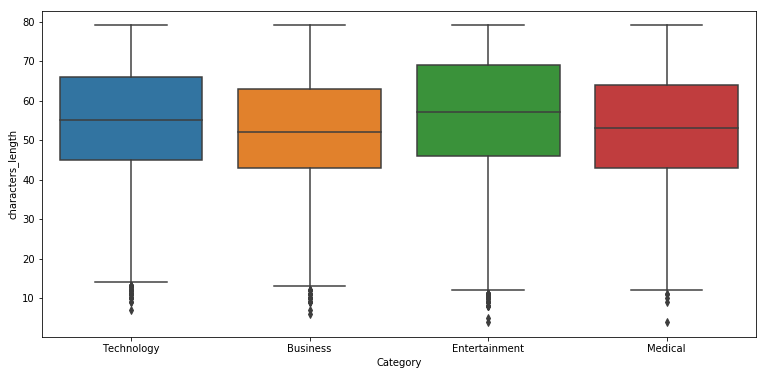

In [40]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=data[data['characters_length']<np.quantile(data['characters_length'],0.95)], x='Category', y='characters_length');

<b>It seems that `Characters Length` does not affecting `Category`. Data looks normal if the outliers data is not included</b>

In [41]:
Counter(" ".join(data["News Title"]).split()).most_common(10)

[('to', 13044),
 ('in', 8897),
 ('...', 8377),
 ('of', 7626),
 ('for', 6676),
 ('the', 6048),
 ('on', 4998),
 ('and', 4957),
 ('The', 3984),
 ('a', 3389)]

In [42]:
Counter(" ".join(data[data['Category']=='Technology']["News Title"]).split()).most_common(10)

[('to', 4047),
 ('for', 1940),
 ('in', 1939),
 ('...', 1796),
 ('the', 1753),
 ('of', 1630),
 ('Google', 1433),
 ('and', 1344),
 ('on', 1299),
 ('Apple', 1134)]

In [43]:
Counter(" ".join(data[data['Category']=='Business']["News Title"]).split()).most_common(10)

[('to', 4011),
 ('in', 2849),
 ('for', 1940),
 ('of', 1666),
 ('on', 1661),
 ('...', 1508),
 ('US', 1422),
 ('the', 1030),
 ('as', 992),
 ('and', 762)]

In [44]:
Counter(" ".join(data[data['Category']=='Entertainment']["News Title"]).split()).most_common(10)

[('...', 4363),
 ('to', 3485),
 ('of', 3294),
 ('the', 2802),
 ('in', 2798),
 ('and', 2450),
 ('The', 2439),
 ('for', 1968),
 ('on', 1661),
 ('a', 1501)]

In [45]:
Counter(" ".join(data[data['Category']=='Medical']["News Title"]).split()).most_common(10)

[('to', 1501),
 ('in', 1311),
 ('of', 1036),
 ('for', 828),
 ('...', 710),
 ('Ebola', 544),
 ('the', 463),
 ('and', 401),
 ('on', 377),
 ('a', 312)]

<b>Many irrelevant words dominating the most frequent appear words and it spread out across categories. Data cleansing should be able to handle this situation.</b>

# Summary

1. No missing data.
2. Category is imbalance especially for `Medical` category.
3. `Characters Length` does not impact the Category disribution too much.
4. Many irrelevant words dominating the most frequent appear words and it spread out across categories.

# Data Preparation 

In [46]:
target = 'Category'
features = [item for item in data.columns if item!=target]
features

['No', 'News Title', 'characters_length']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(data[features], 
                                                    data[target], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [48]:
# pd.concat([X_train, y_train], axis=1).to_csv('news_data/train.csv')
# pd.concat([X_test, y_test], axis=1).to_csv('news_data/valid.csv')

# Text cleaning

In [23]:
X_train.head()

,No,News Title,characters_length
59131,59132,IKEA US Adopts New Minimum Hourly Wage Structure,48
108,109,"Bob Geldof pays tribute to ""beautiful"" Peaches",46
2440,2441,Miley Cyrus Cancels North Carolina Concert 30 ...,71
35243,35244,Walking Dead spoilers: Carl should fear the Ma...,53
53679,53680,"Justin Bieber's Wild Party With Manziel, Tyres...",77


In [24]:
special_characters = string.punctuation

def strip_character(dataCol):
    r = re.compile(r'[^a-zA-Z !@#$%&*_+-=|\:";<>,./()[\]{}\']')
    return r.sub('', dataCol)

def remove_numbers(dataCol):
    return re.sub(r'\d+', '', dataCol)

def remove_non_words(dataCol):
    return re.sub(r"\W", " ", dataCol, flags=re.I)

def remove_single_character(dataCol):
    return re.sub(r"\s+[a-zA-Z]\s+", " ", dataCol)

In [25]:
def remove_possesive_pronouns(data):
    # Remove possesive pronouns first
    data['Content_Parsed_1'] = data['News Title'].str.replace("'s", "")
    data['Content_Parsed_1'] = data['Content_Parsed_1'].str.replace("$", " money ")
    
    return data

X_train = remove_possesive_pronouns(X_train)
X_test = remove_possesive_pronouns(X_test)

In [26]:
X_train.head()

,No,News Title,characters_length,Content_Parsed_1
59131,59132,IKEA US Adopts New Minimum Hourly Wage Structure,48,IKEA US Adopts New Minimum Hourly Wage Structure
108,109,"Bob Geldof pays tribute to ""beautiful"" Peaches",46,"Bob Geldof pays tribute to ""beautiful"" Peaches"
2440,2441,Miley Cyrus Cancels North Carolina Concert 30 ...,71,Miley Cyrus Cancels North Carolina Concert 30 ...
35243,35244,Walking Dead spoilers: Carl should fear the Ma...,53,Walking Dead spoilers: Carl should fear the Ma...
53679,53680,"Justin Bieber's Wild Party With Manziel, Tyres...",77,"Justin Bieber Wild Party With Manziel, Tyrese,..."


In [27]:
def remove_special_characters(data):
    # Remove special characters
    data['Content_Parsed_2'] = data['Content_Parsed_1'].str.replace("\t", " ")
    data['Content_Parsed_2'] = data['Content_Parsed_2'].str.replace("\n", " ")
    data['Content_Parsed_2'] = data['Content_Parsed_2'].str.replace('"', '')
    data['Content_Parsed_2'] = data['Content_Parsed_2'].apply(strip_character)
    data['Content_Parsed_2'] = data['Content_Parsed_2'].apply(remove_numbers)
    data['Content_Parsed_2'] = data['Content_Parsed_2'].apply(remove_non_words)
    data['Content_Parsed_2'] = data['Content_Parsed_2'].apply(remove_single_character)
    
    return data

X_train = remove_special_characters(X_train)
X_test = remove_special_characters(X_test)

In [28]:
X_train.head()

,No,News Title,characters_length,Content_Parsed_1,Content_Parsed_2
59131,59132,IKEA US Adopts New Minimum Hourly Wage Structure,48,IKEA US Adopts New Minimum Hourly Wage Structure,IKEA US Adopts New Minimum Hourly Wage Structure
108,109,"Bob Geldof pays tribute to ""beautiful"" Peaches",46,"Bob Geldof pays tribute to ""beautiful"" Peaches",Bob Geldof pays tribute to beautiful Peaches
2440,2441,Miley Cyrus Cancels North Carolina Concert 30 ...,71,Miley Cyrus Cancels North Carolina Concert 30 ...,Miley Cyrus Cancels North Carolina Concert 30 ...
35243,35244,Walking Dead spoilers: Carl should fear the Ma...,53,Walking Dead spoilers: Carl should fear the Ma...,Walking Dead spoilers: Carl should fear the Ma...
53679,53680,"Justin Bieber's Wild Party With Manziel, Tyres...",77,"Justin Bieber Wild Party With Manziel, Tyrese,...","Justin Bieber Wild Party With Manziel, Tyrese,..."


<b>Some special characters still exist.</b>

In [29]:
def remove_special_character_2(data):
    
    # Remove left special characters    
    data['Content_Parsed_3'] = data['Content_Parsed_2']
    additional_special_characters = list("?:!.,;'+")
    for item in additional_special_characters:
        data['Content_Parsed_3'] = data['Content_Parsed_3'].str.replace(item, '')
    
    return data

X_train = remove_special_character_2(X_train)
X_test = remove_special_character_2(X_test)

In [30]:
X_train.head()

,No,News Title,characters_length,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3
59131,59132,IKEA US Adopts New Minimum Hourly Wage Structure,48,IKEA US Adopts New Minimum Hourly Wage Structure,IKEA US Adopts New Minimum Hourly Wage Structure,IKEA US Adopts New Minimum Hourly Wage Structure
108,109,"Bob Geldof pays tribute to ""beautiful"" Peaches",46,"Bob Geldof pays tribute to ""beautiful"" Peaches",Bob Geldof pays tribute to beautiful Peaches,Bob Geldof pays tribute to beautiful Peaches
2440,2441,Miley Cyrus Cancels North Carolina Concert 30 ...,71,Miley Cyrus Cancels North Carolina Concert 30 ...,Miley Cyrus Cancels North Carolina Concert 30 ...,Miley Cyrus Cancels North Carolina Concert 30 ...
35243,35244,Walking Dead spoilers: Carl should fear the Ma...,53,Walking Dead spoilers: Carl should fear the Ma...,Walking Dead spoilers: Carl should fear the Ma...,Walking Dead spoilers Carl should fear the Mar...
53679,53680,"Justin Bieber's Wild Party With Manziel, Tyres...",77,"Justin Bieber Wild Party With Manziel, Tyrese,...","Justin Bieber Wild Party With Manziel, Tyrese,...",Justin Bieber Wild Party With Manziel Tyrese M...


In [31]:
def lower_text(data):
    data['Content_Parsed_4'] = data['Content_Parsed_3'].str.lower()
    return data

X_train = lower_text(X_train)
X_test = lower_text(X_test)

In [32]:
X_train.head()

,No,News Title,characters_length,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4
59131,59132,IKEA US Adopts New Minimum Hourly Wage Structure,48,IKEA US Adopts New Minimum Hourly Wage Structure,IKEA US Adopts New Minimum Hourly Wage Structure,IKEA US Adopts New Minimum Hourly Wage Structure,ikea us adopts new minimum hourly wage structure
108,109,"Bob Geldof pays tribute to ""beautiful"" Peaches",46,"Bob Geldof pays tribute to ""beautiful"" Peaches",Bob Geldof pays tribute to beautiful Peaches,Bob Geldof pays tribute to beautiful Peaches,bob geldof pays tribute to beautiful peaches
2440,2441,Miley Cyrus Cancels North Carolina Concert 30 ...,71,Miley Cyrus Cancels North Carolina Concert 30 ...,Miley Cyrus Cancels North Carolina Concert 30 ...,Miley Cyrus Cancels North Carolina Concert 30 ...,miley cyrus cancels north carolina concert 30 ...
35243,35244,Walking Dead spoilers: Carl should fear the Ma...,53,Walking Dead spoilers: Carl should fear the Ma...,Walking Dead spoilers: Carl should fear the Ma...,Walking Dead spoilers Carl should fear the Mar...,walking dead spoilers carl should fear the mar...
53679,53680,"Justin Bieber's Wild Party With Manziel, Tyres...",77,"Justin Bieber Wild Party With Manziel, Tyrese,...","Justin Bieber Wild Party With Manziel, Tyrese,...",Justin Bieber Wild Party With Manziel Tyrese M...,justin bieber wild party with manziel tyrese m...


In [33]:
def stemming_lemmatization(data):
    
    wordnet_lemmatizer = WordNetLemmatizer()
    
    nrows = len(data)
    lemmatized_text_list = []

    for row in range(0, nrows):

        # Create an empty list containing lemmatized words
        lemmatized_list = []

        # Save the text and its words into an object
        text = data.iloc[row]['Content_Parsed_4']
        text_words = text.split(" ")

        # Iterate through every word to lemmatize
        for word in text_words:
            lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))

        # Join the list
        lemmatized_text = " ".join(lemmatized_list)

        # Append to the list containing the texts
        lemmatized_text_list.append(lemmatized_text)
    
    data['Content_Parsed_5'] = lemmatized_text_list
    
    return data

In [34]:
X_train = stemming_lemmatization(X_train)
X_test = stemming_lemmatization(X_test)

In [35]:
X_train.head()

,No,News Title,characters_length,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4,Content_Parsed_5
59131,59132,IKEA US Adopts New Minimum Hourly Wage Structure,48,IKEA US Adopts New Minimum Hourly Wage Structure,IKEA US Adopts New Minimum Hourly Wage Structure,IKEA US Adopts New Minimum Hourly Wage Structure,ikea us adopts new minimum hourly wage structure,ikea us adopt new minimum hourly wage structure
108,109,"Bob Geldof pays tribute to ""beautiful"" Peaches",46,"Bob Geldof pays tribute to ""beautiful"" Peaches",Bob Geldof pays tribute to beautiful Peaches,Bob Geldof pays tribute to beautiful Peaches,bob geldof pays tribute to beautiful peaches,bob geldof pay tribute to beautiful peach
2440,2441,Miley Cyrus Cancels North Carolina Concert 30 ...,71,Miley Cyrus Cancels North Carolina Concert 30 ...,Miley Cyrus Cancels North Carolina Concert 30 ...,Miley Cyrus Cancels North Carolina Concert 30 ...,miley cyrus cancels north carolina concert 30 ...,miley cyrus cancel north carolina concert 30 m...
35243,35244,Walking Dead spoilers: Carl should fear the Ma...,53,Walking Dead spoilers: Carl should fear the Ma...,Walking Dead spoilers: Carl should fear the Ma...,Walking Dead spoilers Carl should fear the Mar...,walking dead spoilers carl should fear the mar...,walk dead spoilers carl should fear the marauders
53679,53680,"Justin Bieber's Wild Party With Manziel, Tyres...",77,"Justin Bieber Wild Party With Manziel, Tyrese,...","Justin Bieber Wild Party With Manziel, Tyrese,...",Justin Bieber Wild Party With Manziel Tyrese M...,justin bieber wild party with manziel tyrese m...,justin bieber wild party with manziel tyrese m...


In [36]:
def remove_stop_words(data):
    
    stop_words = list(stopwords.words('english'))
    
    data['Content_Parsed_6'] = data['Content_Parsed_5']

    for stop_word in stop_words:

        regex_stopword = r"\b" + stop_word + r"\b"
        data['Content_Parsed_6'] = data['Content_Parsed_6'].str.replace(regex_stopword, '')
        
    return data

In [37]:
X_train = remove_stop_words(X_train)
X_test = remove_stop_words(X_test)

In [38]:
X_train.head()

,No,News Title,characters_length,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4,Content_Parsed_5,Content_Parsed_6
59131,59132,IKEA US Adopts New Minimum Hourly Wage Structure,48,IKEA US Adopts New Minimum Hourly Wage Structure,IKEA US Adopts New Minimum Hourly Wage Structure,IKEA US Adopts New Minimum Hourly Wage Structure,ikea us adopts new minimum hourly wage structure,ikea us adopt new minimum hourly wage structure,ikea us adopt new minimum hourly wage structure
108,109,"Bob Geldof pays tribute to ""beautiful"" Peaches",46,"Bob Geldof pays tribute to ""beautiful"" Peaches",Bob Geldof pays tribute to beautiful Peaches,Bob Geldof pays tribute to beautiful Peaches,bob geldof pays tribute to beautiful peaches,bob geldof pay tribute to beautiful peach,bob geldof pay tribute beautiful peach
2440,2441,Miley Cyrus Cancels North Carolina Concert 30 ...,71,Miley Cyrus Cancels North Carolina Concert 30 ...,Miley Cyrus Cancels North Carolina Concert 30 ...,Miley Cyrus Cancels North Carolina Concert 30 ...,miley cyrus cancels north carolina concert 30 ...,miley cyrus cancel north carolina concert 30 m...,miley cyrus cancel north carolina concert 30 m...
35243,35244,Walking Dead spoilers: Carl should fear the Ma...,53,Walking Dead spoilers: Carl should fear the Ma...,Walking Dead spoilers: Carl should fear the Ma...,Walking Dead spoilers Carl should fear the Mar...,walking dead spoilers carl should fear the mar...,walk dead spoilers carl should fear the marauders,walk dead spoilers carl fear marauders
53679,53680,"Justin Bieber's Wild Party With Manziel, Tyres...",77,"Justin Bieber Wild Party With Manziel, Tyrese,...","Justin Bieber Wild Party With Manziel, Tyrese,...",Justin Bieber Wild Party With Manziel Tyrese M...,justin bieber wild party with manziel tyrese m...,justin bieber wild party with manziel tyrese m...,justin bieber wild party manziel tyrese maywe...


In [39]:
def show_data_transformation(data,index):
    print('Original data:')
    print(data.iloc[index]['News Title'])
    print()
    print('After remove possesive pronouns:')
    print(data.iloc[index]['Content_Parsed_1'])
    print()
    print('After remove special characters:')
    print(data.iloc[index]['Content_Parsed_2'])
    print()
    print('After remove left special characters for 2nd times:')
    print(data.iloc[index]['Content_Parsed_3'])
    print()
    print('After lower the text:')
    print(data.iloc[index]['Content_Parsed_4'])
    print()
    print('After stemming and lemmatization:')
    print(data.iloc[index]['Content_Parsed_5'])
    print()
    print('After remove stop words:')
    print(data.iloc[index]['Content_Parsed_6'])
    

In [40]:
show_data_transformation(X_train,1)

Original data:
Bob Geldof pays tribute to "beautiful" Peaches

After remove possesive pronouns:
Bob Geldof pays tribute to "beautiful" Peaches

After remove special characters:
Bob Geldof pays tribute to beautiful Peaches

After remove left special characters for 2nd times:
Bob Geldof pays tribute to beautiful Peaches

After lower the text:
bob geldof pays tribute to beautiful peaches

After stemming and lemmatization:
bob geldof pay tribute to beautiful peach

After remove stop words:
bob geldof pay tribute  beautiful peach


In [41]:
show_data_transformation(X_train,2)

Original data:
Miley Cyrus Cancels North Carolina Concert 30 Minutes Before Start Time

After remove possesive pronouns:
Miley Cyrus Cancels North Carolina Concert 30 Minutes Before Start Time

After remove special characters:
Miley Cyrus Cancels North Carolina Concert 30 Minutes Before Start Time

After remove left special characters for 2nd times:
Miley Cyrus Cancels North Carolina Concert 30 Minutes Before Start Time

After lower the text:
miley cyrus cancels north carolina concert 30 minutes before start time

After stemming and lemmatization:
miley cyrus cancel north carolina concert 30 minutes before start time

After remove stop words:
miley cyrus cancel north carolina concert 30 minutes  start time


In [42]:
X_train.head()

,No,News Title,characters_length,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4,Content_Parsed_5,Content_Parsed_6
59131,59132,IKEA US Adopts New Minimum Hourly Wage Structure,48,IKEA US Adopts New Minimum Hourly Wage Structure,IKEA US Adopts New Minimum Hourly Wage Structure,IKEA US Adopts New Minimum Hourly Wage Structure,ikea us adopts new minimum hourly wage structure,ikea us adopt new minimum hourly wage structure,ikea us adopt new minimum hourly wage structure
108,109,"Bob Geldof pays tribute to ""beautiful"" Peaches",46,"Bob Geldof pays tribute to ""beautiful"" Peaches",Bob Geldof pays tribute to beautiful Peaches,Bob Geldof pays tribute to beautiful Peaches,bob geldof pays tribute to beautiful peaches,bob geldof pay tribute to beautiful peach,bob geldof pay tribute beautiful peach
2440,2441,Miley Cyrus Cancels North Carolina Concert 30 ...,71,Miley Cyrus Cancels North Carolina Concert 30 ...,Miley Cyrus Cancels North Carolina Concert 30 ...,Miley Cyrus Cancels North Carolina Concert 30 ...,miley cyrus cancels north carolina concert 30 ...,miley cyrus cancel north carolina concert 30 m...,miley cyrus cancel north carolina concert 30 m...
35243,35244,Walking Dead spoilers: Carl should fear the Ma...,53,Walking Dead spoilers: Carl should fear the Ma...,Walking Dead spoilers: Carl should fear the Ma...,Walking Dead spoilers Carl should fear the Mar...,walking dead spoilers carl should fear the mar...,walk dead spoilers carl should fear the marauders,walk dead spoilers carl fear marauders
53679,53680,"Justin Bieber's Wild Party With Manziel, Tyres...",77,"Justin Bieber Wild Party With Manziel, Tyrese,...","Justin Bieber Wild Party With Manziel, Tyrese,...",Justin Bieber Wild Party With Manziel Tyrese M...,justin bieber wild party with manziel tyrese m...,justin bieber wild party with manziel tyrese m...,justin bieber wild party manziel tyrese maywe...


In [43]:
X_train = X_train[features+['Content_Parsed_6']]
X_train = X_train.rename(columns={'Content_Parsed_6': 'Content_Parsed'})

X_test = X_test[features+['Content_Parsed_6']]
X_test = X_test.rename(columns={'Content_Parsed_6': 'Content_Parsed'})


X_train.head()

,No,News Title,characters_length,Content_Parsed
59131,59132,IKEA US Adopts New Minimum Hourly Wage Structure,48,ikea us adopt new minimum hourly wage structure
108,109,"Bob Geldof pays tribute to ""beautiful"" Peaches",46,bob geldof pay tribute beautiful peach
2440,2441,Miley Cyrus Cancels North Carolina Concert 30 ...,71,miley cyrus cancel north carolina concert 30 m...
35243,35244,Walking Dead spoilers: Carl should fear the Ma...,53,walk dead spoilers carl fear marauders
53679,53680,"Justin Bieber's Wild Party With Manziel, Tyres...",77,justin bieber wild party manziel tyrese maywe...


In [49]:
tmp_df = pd.concat([X_train, y_train], axis=1)

In [50]:
Counter(" ".join(tmp_df["Content_Parsed"]).split()).most_common(10)

[('new', 3047),
 ('us', 2260),
 ('say', 1522),
 ('google', 1498),
 ('apple', 1268),
 ('get', 1264),
 ('-', 1167),
 ('report', 1133),
 ('star', 1098),
 ('show', 1081)]

In [51]:
Counter(" ".join(tmp_df[tmp_df['Category']=='Technology']["Content_Parsed"]).split()).most_common(10)

[('google', 1386),
 ('apple', 1148),
 ('new', 1010),
 ('samsung', 940),
 ('microsoft', 726),
 ('galaxy', 718),
 ('facebook', 701),
 ('launch', 545),
 ('android', 530),
 ('one', 505)]

In [53]:
Counter(" ".join(tmp_df[tmp_df['Category']=='Business']["Content_Parsed"]).split()).most_common(10)

[('us', 1289),
 ('stock', 733),
 ('new', 569),
 ('china', 554),
 ('price', 485),
 ('say', 475),
 ('bank', 462),
 ('market', 455),
 ('rise', 447),
 ('deal', 428)]

In [54]:
Counter(" ".join(tmp_df[tmp_df['Category']=='Entertainment']["Content_Parsed"]).split()).most_common(10)

[('new', 1164),
 ('star', 1027),
 ('kardashian', 731),
 ('kim', 724),
 ('show', 672),
 ('season', 659),
 ('get', 610),
 ('2014', 593),
 ('game', 578),
 ('video', 573)]

In [56]:
Counter(" ".join(tmp_df[tmp_df['Category']=='Medical']["Content_Parsed"]).split()).most_common(10)

[('ebola', 476),
 ('study', 434),
 ('cancer', 352),
 ('health', 337),
 ('new', 304),
 ('us', 272),
 ('may', 272),
 ('say', 258),
 ('mers', 239),
 ('virus', 237)]

<b>Data looks more make sense after data cleaning.</b>

# Label Encoding

Encode the target feature

In [57]:
label_encoders = {}

In [58]:
label_encoders[target] = LabelEncoder()        
label_encoders[target].fit(y_train)  

y_train = label_encoders[target].transform(y_train)
y_test = label_encoders[target].transform(y_test)

In [60]:
# filename = 'news_data/news_label_encoders.pickle'
# save_as_pickle(filename,label_encoders)

# Text representation

Convert text into features

In [61]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train['Content_Parsed'])
X_test_counts = count_vect.transform(X_test['Content_Parsed'])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)

In [80]:
# tfidf_df = pd.DataFrame(X_train_tfidf.todense(), columns=count_vect.get_feature_names())

In [63]:
# filename = 'news_data/count_vect.pickle'
# save_as_pickle(filename,count_vect)

# filename = 'news_data/tfidf_transformer.pickle'
# save_as_pickle(filename,tfidf_transformer)


# Model Building

In [64]:
rf = RandomForestClassifier(random_state = 42)

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [65]:
rf.fit(X_train_tfidf, y_train)
predictions = rf.predict(X_test_tfidf)

In [66]:
print(confusion_matrix(y_test, predictions))
print("Accuracy:",accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

[[3135  199   58  215]
 [ 112 4587   42   61]
 [ 122  152 1123   31]
 [ 247  174   35 2814]]
Accuracy: 0.8895246814679179
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3607
           1       0.90      0.96      0.93      4802
           2       0.89      0.79      0.84      1428
           3       0.90      0.86      0.88      3270

    accuracy                           0.89     13107
   macro avg       0.89      0.87      0.88     13107
weighted avg       0.89      0.89      0.89     13107



In [82]:
# importances = rf.feature_importances_
# indices = np.argsort(importances)

# plt.figure(figsize=(12,10))
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [count_vect.get_feature_names()[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

In [67]:
# filename = 'news_data/rf.pickle'
# save_as_pickle(filename,rf)

# SMOTE / Class Weighted 

In [68]:
smote = SMOTE()
X_sm, y_sm = smote.fit_sample(X_train_tfidf, y_train)

In [69]:
rf_ = RandomForestClassifier(random_state=42)
rf_.fit(X_sm, y_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [70]:
predictions = rf_.predict(X_test_tfidf)

In [71]:
print(confusion_matrix(y_test, predictions))
print("Accuracy:",accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

[[3099  202   78  228]
 [ 114 4555   69   64]
 [ 108  124 1172   24]
 [ 242  171   50 2807]]
Accuracy: 0.8875410086213473
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      3607
           1       0.90      0.95      0.92      4802
           2       0.86      0.82      0.84      1428
           3       0.90      0.86      0.88      3270

    accuracy                           0.89     13107
   macro avg       0.88      0.87      0.88     13107
weighted avg       0.89      0.89      0.89     13107



In [72]:
# filename = 'news_data/rf_.pickle'
# save_as_pickle(filename,rf_)

In [83]:
# importances = rf_.feature_importances_
# indices = np.argsort(importances)

# plt.figure(figsize=(12,10))
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

<b>Upsampling the data does not bring too much impact.</b>